In [ ]:
import pandas as pd
from google.colab import drive
import os

drive.mount('/content/gdrive')

path_to_folder = '/content/gdrive/My Drive/Hackaton'

file1_path = os.path.join(path_to_folder, 'поведенческие_паттерны_клиентов_3.csv')
file2_path = os.path.join(path_to_folder, 'транзакции_в_Мобильном_интернет_Банкинге.csv')

df_patterns = pd.read_csv(
    file1_path,
    delimiter=';',
    header=1,
    skiprows=[2],
    encoding='cp1251'
)

df_transactions = pd.read_csv(
    file2_path,
    delimiter=';',
    header=1,
    encoding='cp1251'
)

print("Поведенческие паттерны: первые 5 строк:")
print(df_patterns.head().to_markdown(index=False, numalign="left", stralign="left"))
print("\nТранзакции: первые 5 строк:")
print(df_transactions.head().to_markdown(index=False, numalign="left", stralign="left"))

Mounted at /content/gdrive
Поведенческие паттерны: первые 5 строк:
| transdate                 | cst_dim_id   | monthly_os_changes   | monthly_phone_model_changes   | last_phone_model_categorical   | last_os_categorical   | logins_last_7_days   | logins_last_30_days   | login_frequency_7d   | login_frequency_30d   | freq_change_7d_vs_mean   | logins_7d_over_30d_ratio   | avg_login_interval_30d   | std_login_interval_30d   | var_login_interval_30d   | ewm_login_interval_7d   | burstiness_login_interval   | fano_factor_login_interval   | zscore_avg_login_interval_7d   |
|:--------------------------|:-------------|:---------------------|:------------------------------|:-------------------------------|:----------------------|:---------------------|:----------------------|:---------------------|:----------------------|:-------------------------|:---------------------------|:-------------------------|:-------------------------|:-------------------------|:------------------------|:-----------

# **DATA PREPROCESSING**

In [ ]:
# ОЧИСТКА ДАТАСЕТОВ
def safe_strip(s):
    # удаление лишних пробелов, кавычек
    if isinstance(s, str):
        return s.strip().strip("'")
    return s

pattern_object_cols = df_patterns.select_dtypes(include=['object']).columns
for col in pattern_object_cols:
    df_patterns[col] = df_patterns[col].apply(safe_strip)

df_patterns['cst_dim_id'] = df_patterns['cst_dim_id'].astype(float).round(0).astype('Int64')
df_patterns['transdate'] = pd.to_datetime(df_patterns['transdate'], errors='coerce')
cols_to_float = [
    'login_frequency_30d',
    'freq_change_7d_vs_mean',
    'var_login_interval_30d'
]
for col in cols_to_float:
    df_patterns[col] = pd.to_numeric(df_patterns[col], errors='coerce')

transaction_object_cols = df_transactions.select_dtypes(include=['object']).columns
for col in transaction_object_cols:
    df_transactions[col] = df_transactions[col].apply(safe_strip)

df_transactions['cst_dim_id'] = df_transactions['cst_dim_id'].astype(float).round(0).astype('Int64')
df_transactions['transdate'] = pd.to_datetime(df_transactions['transdate'], errors='coerce')
df_transactions['transdatetime'] = pd.to_datetime(df_transactions['transdatetime'], errors='coerce')

df_patterns.info()
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8586 entries, 0 to 8585
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   transdate                     8586 non-null   datetime64[ns]
 1   cst_dim_id                    8578 non-null   Int64         
 2   monthly_os_changes            8586 non-null   int64         
 3   monthly_phone_model_changes   8586 non-null   int64         
 4   last_phone_model_categorical  8580 non-null   object        
 5   last_os_categorical           8580 non-null   object        
 6   logins_last_7_days            8586 non-null   int64         
 7   logins_last_30_days           8586 non-null   int64         
 8   login_frequency_7d            8586 non-null   float64       
 9   login_frequency_30d           7356 non-null   float64       
 10  freq_change_7d_vs_mean        8559 non-null   float64       
 11  logins_7d_over_30d_ratio      

In [ ]:
# дубликаты в таблице признаков по (cst_dim_id, transdate)
duplicate_count = df_patterns.duplicated(subset=['cst_dim_id', 'transdate']).sum()
print(duplicate_count)

8


In [ ]:
# поскольку у нас 8 дубликатов в таблице df_patterns, мы должны их удалить
df_patterns_unique = df_patterns.drop_duplicates(subset=['cst_dim_id', 'transdate'], keep='first')
duplicate_count = df_patterns_unique.duplicated(subset=['cst_dim_id', 'transdate']).sum()
print(duplicate_count)

0


In [ ]:
# мерджим два датасета
df_merged = df_transactions.merge(df_patterns_unique, on=['cst_dim_id', 'transdate'], how='left')

In [ ]:
df_merged.shape

(13113, 24)

In [ ]:
# количество транзакций без сопоставленных паттернов (пропуски) после объединения
missing_patterns = df_merged['monthly_os_changes'].isna().sum()
print(missing_patterns)

381


In [ ]:
print(df_merged.head().to_markdown(index=False, numalign="left", stralign="left"))

| cst_dim_id   | transdate           | transdatetime       | amount   | docno   | direction                        | target   | monthly_os_changes   | monthly_phone_model_changes   | last_phone_model_categorical   | last_os_categorical   | logins_last_7_days   | logins_last_30_days   | login_frequency_7d   | login_frequency_30d   | freq_change_7d_vs_mean   | logins_7d_over_30d_ratio   | avg_login_interval_30d   | std_login_interval_30d   | var_login_interval_30d   | ewm_login_interval_7d   | burstiness_login_interval   | fano_factor_login_interval   | zscore_avg_login_interval_7d   |
|:-------------|:--------------------|:--------------------|:---------|:--------|:---------------------------------|:---------|:---------------------|:------------------------------|:-------------------------------|:----------------------|:---------------------|:----------------------|:---------------------|:----------------------|:-------------------------|:---------------------------|:-------------------

In [ ]:
# анализ таргет
target_counts = df_merged['target'].value_counts()
target_percentage = df_merged['target'].value_counts(normalize=True) * 100

df_target_summary = pd.DataFrame({
    'target': target_counts.index,
    'count': target_counts.values,
    'proportion': target_percentage.values
})

print(df_target_summary.to_markdown(
    index=False,
    numalign="left",
    stralign="left",
    floatfmt=[".0f", ".0f", ".2f"], # два знака после запятой для proportion
    headers=["target", "count", "proportion (%)"]
))

| target   | count   | proportion (%)   |
|:---------|:--------|:-----------------|
| 0        | 12948   | 98.74            |
| 1        | 165     | 1.26             |


/tmp/ipython-input-1115042473.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=target_counts.index, y=target_counts.values, palette=['skyblue', 'red'])


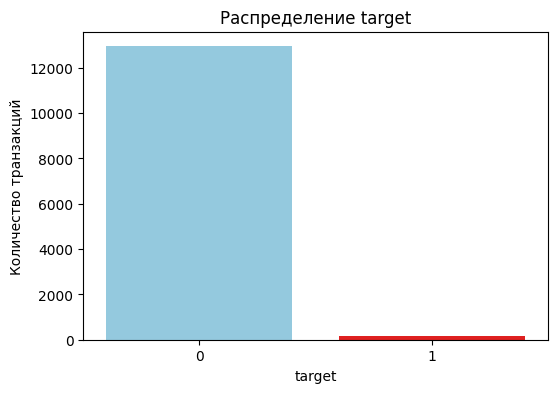

In [ ]:
# визуализация
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.barplot(x=target_counts.index, y=target_counts.values, palette=['skyblue', 'red'])
plt.title('Распределение target')
plt.ylabel('Количество транзакций')
plt.xticks([0, 1], ['0', '1'])
plt.show()

In [ ]:
# базовая статистика по классам
print(df_merged.groupby('target')['amount'].agg(['count', 'mean', 'median', 'std']).to_markdown(numalign="left", stralign="left", floatfmt=".2f"))

| target   | count    | mean      | median    | std       |
|:---------|:---------|:----------|:----------|:----------|
| 0        | 12948.00 | 46701.55  | 10000.00  | 151497.73 |
| 1        | 165.00   | 224649.42 | 102000.00 | 368192.11 |


In [ ]:
# как распределены мошеннические транзакции (target = 1) в тех строках, где отсутствуют поведенческие признаки (368 строк)

missing_features_mask = df_merged['monthly_os_changes'].isna()

missing_target_distribution = df_merged[missing_features_mask]['target'].value_counts()
total_fraud = df_merged['target'].sum()

print(missing_target_distribution.to_markdown(numalign="left", stralign="left"))
print(f"\nОбщее количество мошеннических транзакций в датасете: {total_fraud}")

| target   | count   |
|:---------|:--------|
| 0        | 368     |
| 1        | 13      |

Общее количество мошеннических транзакций в датасете: 165


In [ ]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13113 entries, 0 to 13112
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   cst_dim_id                    13107 non-null  Int64         
 1   transdate                     13113 non-null  datetime64[ns]
 2   transdatetime                 13113 non-null  datetime64[ns]
 3   amount                        13113 non-null  float64       
 4   docno                         13113 non-null  int64         
 5   direction                     13113 non-null  object        
 6   target                        13113 non-null  int64         
 7   monthly_os_changes            12732 non-null  float64       
 8   monthly_phone_model_changes   12732 non-null  float64       
 9   last_phone_model_categorical  12729 non-null  object        
 10  last_os_categorical           12729 non-null  object        
 11  logins_last_7_days          

In [ ]:
# импутация поскольку много nan
import numpy as np

df_merged.rename(columns={
    'cst_dim_id': 'user_id',
    'transdatetime': 'timestamp',
    'direction': 'merchant_id',
    'target': 'is_fraud'
}, inplace=True)

# заполняем user_id специальным ID для NaN, чтобы сохранить строки
df_merged['user_id'] = df_merged['user_id'].fillna(-9999).astype(int)

numeric_cols_to_impute = df_merged.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols_to_impute.remove('amount')
numeric_cols_to_impute.remove('is_fraud')

df_merged[numeric_cols_to_impute] = df_merged[numeric_cols_to_impute].fillna(0)

categorical_cols_to_impute = ['last_phone_model_categorical', 'last_os_categorical']
df_merged[categorical_cols_to_impute] = df_merged[categorical_cols_to_impute].fillna('Unknown')

df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13113 entries, 0 to 13112
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   user_id                       13113 non-null  int64         
 1   transdate                     13113 non-null  datetime64[ns]
 2   timestamp                     13113 non-null  datetime64[ns]
 3   amount                        13113 non-null  float64       
 4   docno                         13113 non-null  int64         
 5   merchant_id                   13113 non-null  object        
 6   is_fraud                      13113 non-null  int64         
 7   monthly_os_changes            13113 non-null  float64       
 8   monthly_phone_model_changes   13113 non-null  float64       
 9   last_phone_model_categorical  13113 non-null  object        
 10  last_os_categorical           13113 non-null  object        
 11  logins_last_7_days          

# **FEATURE ENGINEERING**

In [ ]:
# временные признаки
df_merged['hour'] = df_merged['timestamp'].dt.hour
df_merged['day_of_week'] = df_merged['timestamp'].dt.dayofweek # 0=Понедельник, 6=Воскресенье
df_merged['is_weekend'] = (df_merged['day_of_week'] >= 5).astype(int)

# признаки ночного времени (с 22:00 до 6:00)
df_merged['is_night_time'] = ((df_merged['hour'] >= 22) | (df_merged['hour'] <= 6)).astype(int)

# 3. преобразование часа в синус/косинус, чтобы модель понимала, что 23:59 и 00:01 близки)
df_merged['hour_sin'] = np.sin(2 * np.pi * df_merged['hour'] / 24)
df_merged['hour_cos'] = np.cos(2 * np.pi * df_merged['hour'] / 24)

print(df_merged[['timestamp', 'hour', 'is_night_time', 'hour_sin']].head().to_markdown(index=False, numalign="left", stralign="left"))

| timestamp           | hour   | is_night_time   | hour_sin   |
|:--------------------|:-------|:----------------|:-----------|
| 2025-01-05 16:32:02 | 16     | 0               | -0.866025  |
| 2025-03-04 17:41:57 | 17     | 0               | -0.965926  |
| 2025-06-20 10:08:07 | 10     | 0               | 0.5        |
| 2025-07-06 14:52:13 | 14     | 0               | -0.5       |
| 2024-12-18 14:12:25 | 14     | 0               | -0.5       |


In [ ]:
# сортировка данных по клиенту и времени
df_merged.sort_values(by=['user_id', 'timestamp'], inplace=True)

# время с момента предыдущей транзакции (в секундах)
# разница рассчитывается внутри каждой группы user_id
df_merged['time_diff_prev'] = df_merged.groupby('user_id')['timestamp'].diff().dt.total_seconds()

# первая транзакция клиента
df_merged['time_diff_prev'].fillna(99999999, inplace=True)

# признак: транзакция произошла слишком быстро, например, менее 5 минут (300 секунд) с предыдущей транзакции
df_merged['is_rapid_fire'] = (df_merged['time_diff_prev'] < 300).astype(int)

# количество транзакций за 1 и 7 дней
for window in ['1D', '7D']:
    df_merged_indexed = df_merged.set_index('timestamp')

    df_merged[f'tx_count_{window}'] = (
        df_merged_indexed.groupby('user_id')['docno']
        .rolling(window)
        .count()
        .reset_index(level=0, drop=True)
        .values
    )

    df_merged[f'tx_count_{window}'] = df_merged[f'tx_count_{window}'] - 1
    df_merged[f'tx_count_{window}'] = df_merged[f'tx_count_{window}'].fillna(0)


print(df_merged[['user_id', 'timestamp', 'time_diff_prev', 'is_rapid_fire', 'tx_count_1D', 'tx_count_7D']].head().to_markdown(index=False, numalign="left", stralign="left", floatfmt=".0f"))

| user_id   | timestamp           | time_diff_prev   | is_rapid_fire   | tx_count_1D   | tx_count_7D   |
|:----------|:--------------------|:-----------------|:----------------|:--------------|:--------------|
| -9999     | 2024-12-01 09:29:01 | 99999999         | 0               | 0             | 0             |
| -9999     | 2024-12-02 00:29:01 | 54000            | 0               | 1             | 1             |
| -9999     | 2025-02-04 21:13:01 | 5604240          | 0               | 0             | 0             |
| -9999     | 2025-02-04 21:24:03 | 662              | 0               | 1             | 1             |
| -9999     | 2025-02-05 13:44:08 | 58805            | 0               | 2             | 2             |


/tmp/ipython-input-3867180531.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_merged['time_diff_prev'].fillna(99999999, inplace=True)


In [ ]:
df_merged.head()

,user_id,transdate,timestamp,amount,docno,merchant_id,is_fraud,monthly_os_changes,monthly_phone_model_changes,last_phone_model_categorical,...,hour,day_of_week,is_weekend,is_night_time,hour_sin,hour_cos,time_diff_prev,is_rapid_fire,tx_count_1D,tx_count_7D
9897,-9999,2024-12-01,2024-12-01 09:29:01,5000000.0,11051,9be8fe2a0f78615778165b3b2ed9baf8,0,2.0,1.0,"iPhone16,2",...,9,6,1,0,0.707107,-0.707107,99999999.0,0,0.0,0.0
7541,-9999,2024-12-02,2024-12-02 00:29:01,5000000.0,8933,9be8fe2a0f78615778165b3b2ed9baf8,0,2.0,1.0,"iPhone16,2",...,0,0,0,1,0.000000,1.000000,54000.0,0,1.0,1.0
10439,-9999,2025-02-04,2025-02-04 21:13:01,100000.0,5325,4b2556c36e0b8c9e8bdfcb76d4d1a704,0,1.0,1.0,"iPhone14,5",...,21,1,0,0,-0.707107,0.707107,5604240.0,0,0.0,0.0
7777,-9999,2025-02-04,2025-02-04 21:24:03,2000000.0,9708,4b2556c36e0b8c9e8bdfcb76d4d1a704,0,1.0,1.0,"iPhone14,5",...,21,1,0,0,-0.707107,0.707107,662.0,0,1.0,1.0
9836,-9999,2025-02-05,2025-02-05 13:44:08,4000000.0,12955,4b2556c36e0b8c9e8bdfcb76d4d1a704,0,1.0,1.0,Unknown,...,13,2,0,0,-0.258819,-0.965926,58805.0,0,2.0,2.0


In [ ]:
# расчет агрегированной статистики по клиенту
user_amount_stats = df_merged.groupby('user_id')['amount'].agg(['mean', 'std', 'median']).reset_index()
user_amount_stats.columns = ['user_id', 'user_avg_amount', 'user_std_amount', 'user_median_amount']

df_merged = df_merged.merge(user_amount_stats, on='user_id', how='left')

# Z-Score (насколько текущая сумма отличается от среднего, в единицах стандартного отклонения)
df_merged['amount_zscore'] = (
    df_merged['amount'] - df_merged['user_avg_amount']
) / (df_merged['user_std_amount'] + 1e-8)

df_merged['is_amount_outlier'] = (np.abs(df_merged['amount_zscore']) > 3).astype(int)

print(df_merged[['user_id', 'amount', 'user_avg_amount', 'amount_zscore', 'is_amount_outlier']].head().to_markdown(index=False, numalign="left", stralign="left", floatfmt=".2f"))

| user_id   | amount     | user_avg_amount   | amount_zscore   | is_amount_outlier   |
|:----------|:-----------|:------------------|:----------------|:--------------------|
| -9999.00  | 5000000.00 | 2801000.00        | 1.02            | 0.00                |
| -9999.00  | 5000000.00 | 2801000.00        | 1.02            | 0.00                |
| -9999.00  | 100000.00  | 2801000.00        | -1.25           | 0.00                |
| -9999.00  | 2000000.00 | 2801000.00        | -0.37           | 0.00                |
| -9999.00  | 4000000.00 | 2801000.00        | 0.55            | 0.00                |


In [ ]:
df_merged.head()

,user_id,transdate,timestamp,amount,docno,merchant_id,is_fraud,monthly_os_changes,monthly_phone_model_changes,last_phone_model_categorical,...,hour_cos,time_diff_prev,is_rapid_fire,tx_count_1D,tx_count_7D,user_avg_amount,user_std_amount,user_median_amount,amount_zscore,is_amount_outlier
0,-9999,2024-12-01,2024-12-01 09:29:01,5000000.0,11051,9be8fe2a0f78615778165b3b2ed9baf8,0,2.0,1.0,"iPhone16,2",...,-0.707107,99999999.0,0,0.0,0.0,2801000.0,2.164940e+06,3000000.0,1.015732,0
1,-9999,2024-12-02,2024-12-02 00:29:01,5000000.0,8933,9be8fe2a0f78615778165b3b2ed9baf8,0,2.0,1.0,"iPhone16,2",...,1.000000,54000.0,0,1.0,1.0,2801000.0,2.164940e+06,3000000.0,1.015732,0
2,-9999,2025-02-04,2025-02-04 21:13:01,100000.0,5325,4b2556c36e0b8c9e8bdfcb76d4d1a704,0,1.0,1.0,"iPhone14,5",...,0.707107,5604240.0,0,0.0,0.0,2801000.0,2.164940e+06,3000000.0,-1.247610,0
3,-9999,2025-02-04,2025-02-04 21:24:03,2000000.0,9708,4b2556c36e0b8c9e8bdfcb76d4d1a704,0,1.0,1.0,"iPhone14,5",...,0.707107,662.0,0,1.0,1.0,2801000.0,2.164940e+06,3000000.0,-0.369987,0
4,-9999,2025-02-05,2025-02-05 13:44:08,4000000.0,12955,4b2556c36e0b8c9e8bdfcb76d4d1a704,0,1.0,1.0,Unknown,...,-0.965926,58805.0,0,2.0,2.0,2801000.0,2.164940e+06,3000000.0,0.553826,0


In [ ]:
# Merchant Degree
# сколько уникальных пользователей взаимодействовали с каждым получателем (merchant_id).
merchant_user_count = df_merged.groupby('merchant_id')['user_id'].nunique().reset_index()
merchant_user_count.rename(columns={'user_id': 'merchant_user_degree'}, inplace=True)
df_merged = df_merged.merge(merchant_user_count, on='merchant_id', how='left')

# частота встречаемости получателя
merchant_freq = df_merged['merchant_id'].value_counts(normalize=True).reset_index()
merchant_freq.columns = ['merchant_id', 'merchant_frequency']
df_merged = df_merged.merge(merchant_freq, on='merchant_id', how='left')

# создаем признак, который показывает, является ли текущая транзакция первой транзакцией с этим получателем
df_merged['user_merchant_pair'] = df_merged['user_id'].astype(str) + '_' + df_merged['merchant_id']
df_merged['user_merchant_tx_seq'] = df_merged.groupby('user_merchant_pair').cumcount() + 1
df_merged['is_new_merchant_pair'] = (df_merged['user_merchant_tx_seq'] == 1).astype(int)

df_merged.drop(columns=['user_merchant_pair', 'user_merchant_tx_seq'], inplace=True)

df_merged.head()

,user_id,transdate,timestamp,amount,docno,merchant_id,is_fraud,monthly_os_changes,monthly_phone_model_changes,last_phone_model_categorical,...,tx_count_1D,tx_count_7D,user_avg_amount,user_std_amount,user_median_amount,amount_zscore,is_amount_outlier,merchant_user_degree,merchant_frequency,is_new_merchant_pair
0,-9999,2024-12-01,2024-12-01 09:29:01,5000000.0,11051,9be8fe2a0f78615778165b3b2ed9baf8,0,2.0,1.0,"iPhone16,2",...,0.0,0.0,2801000.0,2.164940e+06,3000000.0,1.015732,0,1,0.000153,1
1,-9999,2024-12-02,2024-12-02 00:29:01,5000000.0,8933,9be8fe2a0f78615778165b3b2ed9baf8,0,2.0,1.0,"iPhone16,2",...,1.0,1.0,2801000.0,2.164940e+06,3000000.0,1.015732,0,1,0.000153,0
2,-9999,2025-02-04,2025-02-04 21:13:01,100000.0,5325,4b2556c36e0b8c9e8bdfcb76d4d1a704,0,1.0,1.0,"iPhone14,5",...,0.0,0.0,2801000.0,2.164940e+06,3000000.0,-1.247610,0,1,0.000305,1
3,-9999,2025-02-04,2025-02-04 21:24:03,2000000.0,9708,4b2556c36e0b8c9e8bdfcb76d4d1a704,0,1.0,1.0,"iPhone14,5",...,1.0,1.0,2801000.0,2.164940e+06,3000000.0,-0.369987,0,1,0.000305,0
4,-9999,2025-02-05,2025-02-05 13:44:08,4000000.0,12955,4b2556c36e0b8c9e8bdfcb76d4d1a704,0,1.0,1.0,Unknown,...,2.0,2.0,2801000.0,2.164940e+06,3000000.0,0.553826,0,1,0.000305,0


## **FEATURE IMPORTANCE**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.preprocessing import StandardScaler
import json

X = df_merged.select_dtypes(include=[np.number])
y = df_merged['is_fraud']

X = X.drop(columns=['is_fraud', 'user_id', 'docno'], errors='ignore')
X = X.fillna(0)

In [ ]:
# Random Forest Feature Importance
def get_rf_importances(X, y, n_features_to_keep=None):
    rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced')
    rf.fit(X, y)
    importances = pd.Series(rf.feature_importances_, index=X.columns)
    importances = importances / importances.max()

    return importances.sort_values(ascending=False)

# Mutual Information Feature Importance
def get_mi_importances(X, y, n_features_to_keep=None):
    mi_scores = mutual_info_classif(X, y, random_state=42)
    importances = pd.Series(mi_scores, index=X.columns)
    importances = importances / importances.max()

    return importances.sort_values(ascending=False)

# Оценка независимости признаков (1 - Max_Correlation)
def get_corr_independence_score(X):
    corr_matrix = X.corr().abs()
    independence_scores = {}

    for column in X.columns:
        max_corr = corr_matrix[column].drop(column, errors='ignore').abs().max()
        independence_scores[column] = 1.0 - max_corr

    importances = pd.Series(independence_scores)
    return importances.sort_values(ascending=False)


rf_scores = get_rf_importances(X, y)
mi_scores = get_mi_importances(X, y)
corr_scores = get_corr_independence_score(X)

combined_scores = pd.concat([
    rf_scores.rename('RF_Importance'),
    mi_scores.rename('MI_Importance'),
    corr_scores.rename('Corr_Independence')
], axis=1).fillna(0)

combined_scores['Combined_Score'] = combined_scores.sum(axis=1)

N_TOP_DISPLAY = 20
df_importance_analysis = combined_scores.sort_values('Combined_Score', ascending=False)

print(df_importance_analysis.head(N_TOP_DISPLAY).to_markdown(floatfmt=".4f"))

print(f"\nОбщее количество признаков в анализе: {len(df_importance_analysis)}")

|                              |   RF_Importance |   MI_Importance |   Corr_Independence |   Combined_Score |
|:-----------------------------|----------------:|----------------:|--------------------:|-----------------:|
| merchant_frequency           |          1.0000 |          1.0000 |              0.6101 |           2.6101 |
| is_new_merchant_pair         |          0.5467 |          0.6039 |              0.5999 |           1.7504 |
| amount                       |          0.4036 |          0.5122 |              0.3956 |           1.3113 |
| amount_zscore                |          0.2713 |          0.5752 |              0.3318 |           1.1782 |
| merchant_user_degree         |          0.0109 |          0.1982 |              0.9454 |           1.1545 |
| burstiness_login_interval    |          0.0595 |          0.3223 |              0.5628 |           0.9446 |
| zscore_avg_login_interval_7d |          0.0496 |          0.3907 |              0.4945 |           0.9348 |
| time_dif

In [ ]:
# анализ корреляции
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
highly_correlated_pairs = []
CORR_THRESHOLD = 0.9

for i, col1 in enumerate(upper.columns):
    for col2 in upper.index[i+1:]:
        if upper.loc[col1, col2] >= CORR_THRESHOLD:
            highly_correlated_pairs.append({
                'Feature_1': col1,
                'Feature_2': col2,
                'Correlation': upper.loc[col1, col2]
            })

df_corr_pairs = pd.DataFrame(highly_correlated_pairs)

if not df_corr_pairs.empty:
    print(df_corr_pairs.sort_values('Correlation', ascending=False).to_markdown(index=False, floatfmt=".4f"))


| Feature_1              | Feature_2                |   Correlation |
|:-----------------------|:-------------------------|--------------:|
| logins_last_7_days     | login_frequency_7d       |        1.0000 |
| freq_change_7d_vs_mean | logins_7d_over_30d_ratio |        0.9785 |


In [ ]:
redundant_numerical_features = [
    'login_frequency_7d',
    'freq_change_7d_vs_mean'
]

# удаление избыточных признаков
df_merged_final = df_merged.drop(
    columns=redundant_numerical_features,
    errors='ignore'
).copy()

final_numerical_features = (
    df_merged_final.select_dtypes(include=[np.number]).columns.tolist()
)

features_to_remove = ['is_fraud', 'user_id', 'docno']
for col in features_to_remove:
    if col in final_numerical_features:
        final_numerical_features.remove(col)

final_categorical_features = df_merged_final.select_dtypes(include=['object']).columns.tolist()

final_model_features = final_numerical_features + final_categorical_features

print("числовые признаки")
print(final_numerical_features)
print("\nкатегориальные признаки")
print(final_categorical_features)

print(f"\nобщее количество признаков: {len(final_model_features)}")

числовые признаки
['amount', 'monthly_os_changes', 'monthly_phone_model_changes', 'logins_last_7_days', 'logins_last_30_days', 'login_frequency_30d', 'logins_7d_over_30d_ratio', 'avg_login_interval_30d', 'std_login_interval_30d', 'var_login_interval_30d', 'ewm_login_interval_7d', 'burstiness_login_interval', 'fano_factor_login_interval', 'zscore_avg_login_interval_7d', 'hour', 'day_of_week', 'is_weekend', 'is_night_time', 'hour_sin', 'hour_cos', 'time_diff_prev', 'is_rapid_fire', 'tx_count_1D', 'tx_count_7D', 'user_avg_amount', 'user_std_amount', 'user_median_amount', 'amount_zscore', 'is_amount_outlier', 'merchant_user_degree', 'merchant_frequency', 'is_new_merchant_pair']

категориальные признаки
['merchant_id', 'last_phone_model_categorical', 'last_os_categorical']

общее количество признаков: 35
